In [1]:
import sys
sys.path.insert(0, 'C:/Users/14432/OneDrive/Research/Projects/a549_pcna/src/4_wk_trajectory/')
sys.path.insert(1, 'C:/Users/14432/OneDrive/Research/Projects/A549_pcna/src/3-compute/tools/')

import warnings
warnings.filterwarnings("ignore")

import numpy as np
from skimage import measure
from skimage.segmentation import find_boundaries
from skimage.morphology import opening, closing, remove_small_holes, remove_small_objects, \
                               local_maxima, h_maxima, disk, dilation
from skimage.io import imread
from matplotlib import pyplot as plt
import os
from os import listdir
import pandas as pd
from scipy.stats import kde
import seaborn as sns
import copy
from math import exp,log
import pickle
import scipy.ndimage as ndimage
import scipy.interpolate.fitpack as fitpack
from sklearn import manifold,decomposition,random_projection,cluster,metrics,preprocessing,mixture,model_selection
from sklearn.neighbors import kneighbors_graph,BallTree
from hmmlearn import hmm
# from pymc import MCMC,flib,Model,MAP
# from ripser import Rips,ripser,plot_dgms
from persim import PersImage
import scipy.io as sio
# import kmapper as km
# from kmapper import jupyter
from mpl_toolkits.mplot3d import Axes3D
from cell_class import single_cell,fluor_single_cell
import contour_class
import utility_tools
import image_warp
from contour_tool import df_find_contour_points,find_contour_points,generate_contours,align_contour_to,align_contours
from scipy.signal import medfilt,wiener
from traj_class import single_cell_traj,fluor_single_cell_traj
# import bnpy
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler,QuantileTransformer
from itertools import product
from sklearn.cluster import DBSCAN,KMeans
from sklearn.metrics import silhouette_score,davies_bouldin_score
# from pykalman import KalmanFilter
# from neupy import algorithms, utils
from tslearn.utils import to_time_series,to_time_series_dataset
from tslearn.metrics import dtw_path,dtw_subsequence_path,cdist_gak,cdist_dtw
from tslearn.barycenters import dtw_barycenter_averaging, softdtw_barycenter
from sklearn.manifold import MDS
# import sparse
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels import robust
from matplotlib.patches import Circle, Wedge, Rectangle
from traj_scale import sp_traj_scaling,ssp_traj_scaling
import random
from skimage.measure import regionprops
from skimage.filters.rank import otsu
from traj_tools import find_mother_label

In [2]:
def create_img_env(seg,img,obj_num,bound_ext):
    rps = regionprops(seg)
    w, h = seg.shape
    
    for r in rps:
        if r.label == obj_num:
            bound = r.bbox

            crop_b1 = bound[0]-bound_ext
            if crop_b1<=0:
                crop_b1=0
            crop_b2 = bound[2]+bound_ext
            if crop_b2>=w:
                crop_b2=w
            crop_b3 = bound[1]-bound_ext
            if crop_b3<=0:
                crop_b3=0
            crop_b4 = bound[3]+bound_ext
            if crop_b4>=h:
                crop_b4=h

    img_crop = img[crop_b1:crop_b2,crop_b3:crop_b4]

    return img_crop

In [3]:
check_posi='XY3'
check_trajnum=3578
check_img_num=961

In [4]:
main_path='C:/Users/14432/OneDrive/Research/Projects/a549_pcna/data/'
output_path=main_path+'out/11-2-21_mt_20E-3_lt_35E-2/'
sct_path=output_path+'sct/'
sct_list=sorted(listdir(sct_path))

In [5]:
def find_offspring(df,mitosis_df,family_tree,traj_label):
    mother_label=traj_label
    if mother_label!=-1 and (mitosis_df['mother_traj_label']==mother_label).any():
        family_tree[int(mother_label)]=[]
        sis1_label=mitosis_df.loc[mitosis_df['mother_traj_label']==mother_label,'sis1_traj_label'].values[0]
        sis2_label=mitosis_df.loc[mitosis_df['mother_traj_label']==mother_label,'sis2_traj_label'].values[0]
        if sis1_label!=-1:
            family_tree[int(mother_label)].append(int(sis1_label))
        if sis2_label!=-1:
            family_tree[int(mother_label)].append(int(sis2_label))
        family_tree=find_offspring(df,mitosis_df,family_tree,sis1_label)
        family_tree=find_offspring(df,mitosis_df,family_tree,sis2_label)
        return family_tree
    else:
        return family_tree

In [6]:
def parse(node, tree):
    if node not in tree:
        yield [node]
    else:
        for next_node in tree[node]:
            for r in parse(next_node,tree):
                yield [node]+r

In [7]:
def count_num_fluor_pca_cord(cells,fluor_name,fluor_feature_name):
    for single_cell in cells:
        if hasattr(single_cell,fluor_name+'_feature_values'):
            print('this cell has pca cord')
            num_fluor_pca_cord = len(single_cell.vimentin_haralick_pca_cord)
            print(num_fluor_pca_cord)
            break
    return num_fluor_pca_cord

In [8]:
def generate_fluor_long_traj(df,cells,am_record,traj_df,traj,fluor_name,feature_list,fluor_feature_name):
    
    haralick_labels = ["Angular Second Moment",
                   "Contrast",
                   "Correlation",
                   "Sum of Squares: Variance",
                   "Inverse Difference Moment",
                   "Sum Average",
                   "Sum Variance",
                   "Sum Entropy",
                   "Entropy",
                   "Difference Variance",
                   "Difference Entropy",
                   "Information Measure of Correlation 1",
                   "Information Measure of Correlation 2",
                    "Maximal Correlation Coefficient"]
    
    
    traj_record=pd.DataFrame(traj_df.loc[:,'1':str(time_span)])
    traj_record=traj_record.values
    traj_quan,traj_len=traj_record.shape[0],traj_record.shape[1]
    
    traj_xy=[]
    traj_feature=[]
    traj_contour=[]
    traj_cord=[]
    traj_seri=[]
    traj_am_flag=[]
 
    traj_vim_feature_values=[]
    traj_vim_haralick=[]
    traj_vim_norm_haralick=[]
    traj_vim_pca_cord=[]
    
    traj_pcna_feature_values=[]
    traj_pcna_haralick=[]
    traj_pcna_norm_haralick=[]
    traj_pcna_pca_cord=[]

    num_vim_pca_cord=count_num_fluor_pca_cord(cells,fluor_name[0],fluor_feature_name[:2])
    num_pcna_pca_cord=count_num_fluor_pca_cord(cells,fluor_name[1],fluor_feature_name[2:])
    
    for img_num in range(1,traj_len+1):
        obj_num=traj[img_num-1]
        if obj_num!=-1:
            ind=df.loc[(df['ImageNumber']==img_num)&(df['ObjectNumber']==obj_num)].index.tolist()[0]

            if hasattr(cells[ind],fluor_name[0]+'_feature_values') and \
                hasattr(cells[ind],fluor_name[1]+'_feature_values'):
                
                cell_pcna_feature_values = cells[ind].pcna_feature_values[3]
                num_zero_haralick = sum(x==0 for x in cell_pcna_feature_values)

                if num_zero_haralick != len(cell_pcna_feature_values):
            
                    if hasattr(cells[ind],'cell_contour') and hasattr(cells[ind],'pca_cord'):
                        traj_contour.append(cells[ind].cell_contour.points.flatten())
                        traj_cord.append(cells[ind].pca_cord)
                        traj_seri.append([img_num,obj_num])
                        traj_xy.append([df.loc[ind,'Cell_AreaShape_Center_X'],df.loc[ind,'Cell_AreaShape_Center_Y']])
                        traj_feature.append(df.loc[ind,'Cell_AreaShape_Area':'Cell_AreaShape_Solidity'].values.tolist())

                        if ((am_record['ImageNumber']==img_num)&(am_record['ObjectNumber']==obj_num)).any():
                            am_flag=np.asscalar(am_record.loc[(am_record['ImageNumber']==img_num)&\
                                                              (am_record['ObjectNumber']==obj_num),'am_flag'].values)
                            traj_am_flag.append(am_flag)
                        else:
                            traj_am_flag.append(0)

                        exec('traj_vim_feature_values.append(np.array(cells[ind].'+fluor_name[0]+'_feature_values[:3]))')
                        exec('traj_vim_haralick.append(np.array(cells[ind].'+fluor_name[0]+'_feature_values[3]))')
                        exec('traj_vim_norm_haralick.append(np.array(cells[ind].'+fluor_name[0]+'_feature_values[4]))')
                        exec('traj_vim_pca_cord.append(cells[ind].'+fluor_feature_name[0]+'_pca_cord)')

                        exec('traj_pcna_feature_values.append(np.array(cells[ind].'+fluor_name[1]+'_feature_values[:3]))')
                        exec('traj_pcna_haralick.append(np.array(cells[ind].'+fluor_name[1]+'_feature_values[3]))')
                        exec('traj_pcna_norm_haralick.append(np.array(cells[ind].'+fluor_name[1]+'_feature_values[4]))')
                        exec('traj_pcna_pca_cord.append(cells[ind].'+fluor_feature_name[1]+'_pca_cord)')
    
    traj_xy=np.asarray(traj_xy)
    traj_feature=np.asarray(traj_feature)
    traj_contour=np.asarray(traj_contour)
    traj_cord=np.asarray(traj_cord)
    traj_seri=np.asarray(traj_seri)
    
    traj_am_flag=np.asarray(traj_am_flag)
    
    traj_vim_feature_values=np.asarray(traj_vim_feature_values)
    traj_vim_haralick=np.asarray(traj_vim_haralick)
    traj_vim_norm_haralick=np.asarray(traj_vim_norm_haralick)
    traj_vim_pca_cord=np.asarray(traj_vim_pca_cord)  
    
    traj_pcna_feature_values=np.asarray(traj_pcna_feature_values)
    traj_pcna_haralick=np.asarray(traj_pcna_haralick)
    traj_pcna_norm_haralick=np.asarray(traj_pcna_norm_haralick)
    traj_pcna_pca_cord=np.asarray(traj_pcna_pca_cord)  
   
#     mask=traj_fluor_feature_values[:,0]!=0
    
        
#     abn_inds=find_abnormal_fluor(traj_vim_feature_values[:,0],traj_seri[:,0])
#     if len(abn_inds)>0:
#         traj_vim_feature_values[abn_inds,:]=0
#         traj_vim_haralick[abn_inds,:]=0
#         traj_vim_norm_haralick[abn_inds,:]=0
#         print(traj_vim_pca_cord.shape)
#         traj_vim_pca_cord[abn_inds,:]=0
    if len(traj_pcna_feature_values) > 0:
        return traj_feature,traj_contour,traj_cord,traj_seri,traj_am_flag,\
               [traj_vim_feature_values[:,0],traj_vim_feature_values[:,1],traj_vim_feature_values[:,2],\
               traj_vim_haralick,traj_vim_norm_haralick],traj_vim_pca_cord,\
               [traj_pcna_feature_values[:,0],traj_pcna_feature_values[:,1],traj_pcna_feature_values[:,2],\
               traj_pcna_haralick,traj_pcna_norm_haralick],traj_pcna_pca_cord
    else:
        return traj_feature,traj_contour,traj_cord,traj_seri,traj_am_flag,\
               traj_vim_feature_values,traj_vim_pca_cord,\
               traj_pcna_feature_values,traj_pcna_pca_cord


In [10]:
time_span = 1729
loss_ratio_thres=0.5
traj_len_thres=144

dir_path=output_path+check_posi+'/'
am_record=pd.read_csv(dir_path+'am_record.csv')
mitosis_df=pd.read_csv(dir_path+'mitosis_record.csv')
df=pd.read_csv(dir_path+'Per_Object_relink.csv')  
traj_df=pd.read_csv(dir_path+'traj_object_num.csv')
with open (dir_path+'cells/'+'fluor_cells', 'rb') as fp:
    cells = pickle.load(fp)

feature_list=['mean_intensity','std_intensity','intensity_range','haralick','norm_haralick']
fluor_feature_name=['vimentin_haralick','pcna_haralick']
    
traj_record=pd.DataFrame(traj_df.loc[:,'1':str(time_span)])
traj_record=traj_record.values
traj_quan,traj_len=traj_record.shape[0],traj_record.shape[1]

cur_traj=traj_record[check_trajnum-1,:]
traj_start_t=np.where(cur_traj!=-1)[0][0]+1

family_tree={}
family_tree=find_offspring(df,mitosis_df,family_tree,traj_label=check_trajnum)
print('family',family_tree)
all_branches=list(list(parse(check_trajnum, family_tree)))

for branch in all_branches:   
    branch_end_label=branch[-1]
    branch_end_traj=traj_record[branch_end_label-1,:]
    branch_end_t=np.where(branch_end_traj!=-1)[0][-1]+1

    long_traj=-1*np.ones((time_span,))
    divide_points=[]
    traj_name=''
    for sub_label in branch:
        sub_traj=traj_record[sub_label-1,:]
        mask=sub_traj!=-1
        if (np.where(sub_traj!=-1)[0][-1]+1)!=branch_end_t:
            divide_points.append(np.where(sub_traj!=-1)[0][-1]+1)
        long_traj[mask]=sub_traj[mask]
        traj_name=traj_name+str(sub_label)+'_'                      

    whole_branch=long_traj[traj_start_t-1:branch_end_t]

    long_traj_loss_ratio=whole_branch[whole_branch==-1].shape[0]*1.0/whole_branch.shape[0]
    print(whole_branch.shape[0])
    if long_traj_loss_ratio<loss_ratio_thres and (branch_end_t-traj_start_t)>=traj_len_thres:

        traj_feature,traj_contour,\
            traj_cord,traj_seri,traj_am_flag,\
            traj_vim_feature_values,traj_vim_pca_cord,\
            traj_pcna_feature_values,traj_pcna_pca_cord=generate_fluor_long_traj(
            df,cells,am_record,\
            traj_df,long_traj,\
            ['vimentin','pcna'],feature_list,fluor_feature_name)

family {3578: [4550, 4552]}
219
this cell has pca cord
6
this cell has pca cord
6
328
this cell has pca cord
6
this cell has pca cord
6


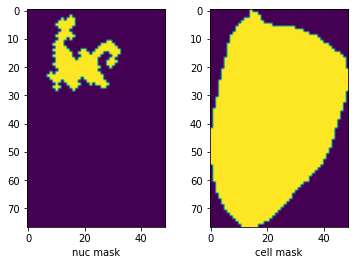

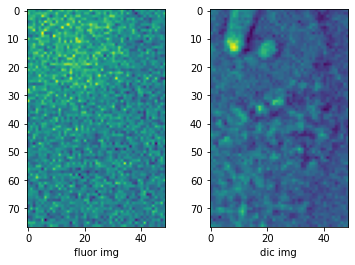

In [83]:
for i in range(len(sct_list)):
    sct_posi = sct_list[i].split('_')[2]
    sct_trajnum = int(sct_list[i].split('_')[3])

    if sct_posi == check_posi and sct_trajnum == check_trajnum: 
        
        with open (sct_path+sct_list[i], 'rb') as fp:
            sct = pickle.load(fp)
        
        fluor_img_path=main_path+'ori/'+sct_posi+'_C2/'
        fluor_img_list=listdir(fluor_img_path)
        
        seg_path=output_path+sct_posi+'/seg/'
        seg_list=listdir(seg_path)
        
        img_path=main_path+'ori/'+sct_posi+'_C1/'
        img_list=listdir(img_path)
        
        sct_seri = sct.traj_seri
#         mask=sct.traj_vimentin_feature_values[0]!=0
        for seri_idx in range(len(sct_seri)):
            if sct_seri[seri_idx][0] == check_img_num:
                check_obj_num = sct_seri[seri_idx][1]
        
        fluor_img=imread(fluor_img_path+fluor_img_list[check_img_num-1])
        seg=imread(seg_path+seg_list[check_img_num-1])
        img=imread(img_path+img_list[check_img_num-1])

        rps=regionprops(seg)
        candi_r=[r for r in rps if r.label==check_obj_num][0]
        candi_box=candi_r.bbox

        cell_mask = (seg == check_obj_num)
        cell_img = (fluor_img*cell_mask)[candi_box[0]:candi_box[2],candi_box[1]:candi_box[3]]
        
        nuc_mask=cell_img>otsu(cell_img,selem=disk(max(cell_img.shape)/2), mask=cell_img>0)
        nuc_mask=remove_small_objects(opening(nuc_mask),100)
        nuc_mask=closing(nuc_mask)
        nuc_mask=remove_small_holes(nuc_mask,100)

        nuc_img=cell_img*nuc_mask

        region_cell_mask = cell_mask[candi_box[0]:candi_box[2], candi_box[1]:candi_box[3]]
        region_img = img[candi_box[0]:candi_box[2], candi_box[1]:candi_box[3]]
        region_fluor_img = fluor_img[candi_box[0]:candi_box[2], candi_box[1]:candi_box[3]]
        
        env_img = create_img_env(seg,img,check_obj_num,75)
        env_fluor_img = create_img_env(seg,fluor_img,check_obj_num,75)

        fig, axs = plt.subplots(1, 2)
        axs[0].imshow(nuc_mask)
        axs[0].set_xlabel('nuc mask')
        axs[1].imshow(region_cell_mask)
        axs[1].set_xlabel('cell mask')
        
        fig, axs = plt.subplots(1, 2)
        axs[0].imshow(region_fluor_img)
        axs[0].set_xlabel('fluor img')
        axs[1].imshow(region_img)
        axs[1].set_xlabel('dic img')
        
        